# 4. Image Segmentation

In [149]:
# Importing all the required libraries
import hashlib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [150]:
# Generating a personalized random seed
username = "prit.kanadiya"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
print(seed)

1379217023


### Implementing GMM class

In [151]:
# We need the K Means class because we will use it to initialize the parameters for GMM.
class KMeansClustering():
    def __init__(self, K, seed):
        '''
        Initializes the KMeansClustering object with the number of clusters (K) and the random seed

        Args:
            K (int): number of clusters
            seed (int): seed value for reproducibility
        '''
        self.K = K
        self.seed = seed
        np.random.seed(seed)

    def fit(self, df, num_iters=50) -> pd.DataFrame:
        '''
        Performs the K-means clustering algorithm on the given data

        Args:
            df (pd.DataFrame): dataset to be clustered
            num_iters (int): maximum number of iterations (default is 50)

        Returns:
            pd.DataFrame: final centroid points of the clusters after fitting the K-means model
        '''
        data = df.copy()
        # Randomly assign K datapoints to be the means
        means = data.sample(n=self.K, random_state=self.seed).reset_index(drop=True)
        
        cols = data.columns
        data["cluster"] = -1
        for iters in range(num_iters):
            # E Step
            distances = np.linalg.norm(data[cols].values[:, None] - means[cols].values, axis=2)
            data['cluster'] = distances.argmin(axis=1)
                
            # M Step
            new_means = data.groupby('cluster')[cols].mean()

            if new_means.equals(means):
                break

            means = new_means.reset_index(drop=True)

            # print(f"Cost after iteration {iters}: {self.getCost(data, means)}")
        
        if (iters == num_iters):
            print(f"K Means failed to converge for {num_iters} iterations.")
        
        self.means = means 
        return means
    
    def predict(self, df) -> pd.Series:
        '''
        Predicts the cluster assignments for each data point based on the learned centroids

        Args:
            df (pd.DataFrame): dataset to be predicted

        Returns:
            pd.Series: cluster assignments for each data point
        '''
        data = df.copy()
        distances = np.linalg.norm(data[['R', 'G', 'B']].values[:, None] - self.means[['R', 'G', 'B']].values, axis=2)
        data['cluster'] = distances.argmin(axis=1)
        self.labels = data['cluster']
        return data['cluster']

In [152]:
class GMM():
    def __init__(self, K, seed):
        '''
        Initializes the GMM object with the number of gaussians (K) and the random seed

        Args:
            K (int): number of gaussians
            seed (int): seed value for reproducibility
        '''
        self.K = K
        self.likelihood_list = []
        np.random.seed(seed)
        self.kmeans = KMeansClustering(K, seed)    # kmeans object to init GMM parameters
    
    def fit(self, df, num_iters=50):
        '''
        Fits the GMM model using EM algorithm on the given data

        Args:
            df (pd.DataFrame): dataset to be clustered
            num_iters (int): max iterations
        '''
        self.likelihood_list = []
        data = df.copy()
        X = data.values.astype(np.float64)  

        # Initializing GMM parameters using kmeans
        means = self.kmeans.fit(data, num_iters)
        self.means = means    # Initializing means
        hard_clusters = self.kmeans.predict(data)

        cov = []
        pi = []
        for i in range(self.K):
            cluster_points = X[hard_clusters == i]
            diff = cluster_points - means.loc[i].values  
            cov_i = (diff.T @ diff) / len(cluster_points)
            cov.append(cov_i)    # Initializing covariances
            pi.append(len(cluster_points) / X.shape[0])    # Initializing mixing coefficients

        cov = np.array(cov)
        pi = np.array(pi)
        means_arr = means.values.astype(np.float64)

        self.means = means
        self.cov = cov
        self.pi = pi

        curr_likelihood = self.getLikelihood(df)
        self.likelihood_list.append(curr_likelihood)

        # Fitting GMM
        # We need to vectorize several elements of code since it takes a lot of time for it to fit on image.
        for iters in range(0, num_iters):

            # E Step
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)
            norm_const = 1.0 / (np.sqrt(((2*np.pi)**X.shape[1]) * det_cov))
            diff = X[:, None, :] - means_arr[None, :, :] 
            exp_term = np.einsum('nkd,kde,nke->nk', diff, inv_cov, diff) 

            responsibility = norm_const[None, :] * np.exp(-0.5 * exp_term) * pi[None, :]    # This is liklihood * prior
            responsibility = responsibility / responsibility.sum(axis=1, keepdims=True) 

            # M Step
            Nk = responsibility.sum(axis=0)  
            means_arr = (responsibility.T @ X) / Nk[:, None]  # (1 / Nk_soft)(sum(ri*xi))

            cov_new = np.zeros_like(cov) 
            for k in range(self.K):
                diff_k = X - means_arr[k] 
                weighted_diff = diff_k * responsibility[:, k][:, None] 
                cov_new[k] = (weighted_diff.T @ diff_k) / Nk[k]
            cov = cov_new

            pi = Nk / X.shape[0] 

            means = pd.DataFrame(means_arr, columns=data.columns)

            self.means = means
            self.cov = cov
            self.pi = pi

            curr_likelihood = self.getLikelihood(df)
            self.likelihood_list.append(curr_likelihood)

            if (iters % 5 == 0):
                print(f"Completed iteration {iters} with likelihood: {curr_likelihood}")
            
            threshold = 1e-2
            if abs(curr_likelihood - self.likelihood_list[-2]) < threshold:
                break

        else:
            print(f"GMM failed to converge in {num_iters} iterations for K = {self.K}.")


    def getMembership(self, df, eps=1e-2):
        '''
        Returns the cluster membership or responsibility for each datapoint

        Args:
            df (pd.DataFrame): dataset to be clustered
            eps (float): small value used to maintain stability

        Returns:
            responsibility (pd.DataFrame): final membership of each point (soft assignments)
        '''
        data = df.copy()
        responsibility = pd.DataFrame(columns=[i for i in range(self.K)])    # This is the responsibility of data point i taken by cluster k

        for i in range(self.K):
            cov_det= np.linalg.det(self.cov[i].astype(np.float64))
            denominator = np.sqrt(((2*np.pi)**(self.cov[0].shape[0]))*(cov_det))
            cov_inv = np.linalg.inv(self.cov[i].astype(np.float64))

            for j, row in data.iterrows():
                prior = self.pi[i]
                x = row.values 
                diff = x - self.means.loc[i].values  
                exp_term = -(diff.T @ (cov_inv @ diff))/2
                likelihood = (1/denominator)*np.exp(exp_term)

                # Responsibility is prior * likelihood
                responsibility.loc[j, i] = prior * likelihood
        
        # Normalizing responsibility
        for i, row in responsibility.iterrows():
            row_sum = sum(row)
            responsibility.loc[i] = row / row_sum
        
        return responsibility
    
    def getLikelihood(self, df, eps=1e-6):
        '''
        Returns the log likelihood of GMM likelihood function

        Args:
            df (pd.DataFrame): dataset to be clustered
            eps (float): small value used to maintain stability

        Returns:
            total (float): log likelihood
        '''
        X = df.values.astype(np.float64)
        K = self.K

        means = self.means.values.astype(np.float64)
        covs = self.cov.astype(np.float64)
        pis = self.pi

        covs_stable = covs + np.eye(covs.shape[1])[None, :, :] * eps
        inv_covs = np.linalg.inv(covs_stable)
        det_covs = np.linalg.det(covs_stable)
        norm_const = 1.0 / np.sqrt((2 * np.pi)**(covs.shape[1]) * det_covs)

        diff = X[:, None, :] - means[None, :, :]
        exp_term = -0.5 * np.einsum('nkd,kde,nke->nk', diff, inv_covs, diff)

        likelihoods = norm_const[None, :] * np.exp(exp_term) * pis[None, :]
        total_log_likelihood = np.sum(np.log(likelihoods.sum(axis=1) + 1e-12))

        return total_log_likelihood

    def drawLikelihood(self): 
        '''
        Plots likelihood vs iterations for given K value
        '''
        plt.plot(self.likelihood_list)
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        plt.title('GMM Log-Likelihood vs Iterations (prit.kanadiya)')
        plt.grid(True)
        plt.text(0.95, 0.85, "prit.kanadiya",
            ha = "right", va = "top",
            transform = plt.gca().transAxes,
            fontsize = 10, color = "gray", alpha=0.7)
        plt.show() 

    def predict(self, df):
        """
        Predict cluster assignments for each pixel.

        Args:
            df (pd.DataFrame): pixel data

        Returns:
            np.array: cluster labels for each pixel
        """
        data = df.values
        N = data.shape[0]
        K = len(self.pi)
        responsibilities = np.zeros((N, K))

        for i in range(K):
            mean = self.means.iloc[i].values
            cov = self.cov[i] + np.eye(self.cov.shape[0]) * 1e-6  # Stability
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)
            norm_const = 1.0 / (((2*np.pi)**(data.shape[1]/2))*np.sqrt(det_cov))

            diff = data - mean
            exp_term = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
            responsibilities[:, i] = self.pi[i] * norm_const * np.exp(-0.5 * exp_term)

        # Assign each pixel to cluster with max responsibility
        labels = np.argmax(responsibilities, axis=1)
        return labels        
                

In [153]:
def create_segmented_image_fixed_colors(labels, image_shape):
    """
    Create segmented image with fixed colors for 3 clusters:

    Args:
        labels (np.array): cluster assignments for each pixel 
        image_shape (tuple): original image shape 

    Returns:
        np.array: segmented image with fixed colors, dtype uint8
    """
    # For the given seed, we fix the color so that it matches visualization 
    color_map = {
        0: [0, 0, 255],   # Red
        1: [0, 255, 0],   # Green
        2: [255, 0, 0],   # Red
    }    

    segmented_img = np.zeros((labels.shape[0], 3), dtype=np.uint8)

    for k in color_map:
        segmented_img[labels == k] = color_map[k]

    segmented_img = segmented_img.reshape(image_shape)
    return segmented_img

In [154]:
img1 = cv2.imread("../assets/data/satellite_1.png")
print(img1.shape)

# Creating a pd dataframe from image
df1 = pd.DataFrame(columns=["B", "G", "R"])

pixels = img1.reshape(-1, 3).astype("int32")
df1 = pd.DataFrame(pixels, columns=["B", "G", "R"])

# Scaling the values to be between 0 and 1
df1 = pd.DataFrame(pixels / 255.0, columns=["B", "G", "R"])

# Display info
print(len(df1))
print(df1.info())
print(df1.head())

(767, 1000, 3)
767000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767000 entries, 0 to 766999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   B       767000 non-null  float64
 1   G       767000 non-null  float64
 2   R       767000 non-null  float64
dtypes: float64(3)
memory usage: 17.6 MB
None
          B         G         R
0  0.294118  0.305882  0.203922
1  0.200000  0.231373  0.086275
2  0.196078  0.270588  0.054902
3  0.250980  0.356863  0.105882
4  0.203922  0.321569  0.090196


In [155]:
# Initializing K Means Clustering Class
K = 3    # Land, water and vegetation

gmm = GMM(K, seed)
gmm.fit(df1, 100)

Completed iteration 0 with likelihood: 3036726.851383401
Completed iteration 5 with likelihood: 3115594.8145642495
Completed iteration 10 with likelihood: 3139996.851600439
Completed iteration 15 with likelihood: 3151347.546436296
Completed iteration 20 with likelihood: 3160174.2246548017
Completed iteration 25 with likelihood: 3169979.611197593
Completed iteration 30 with likelihood: 3186156.5269652056
Completed iteration 35 with likelihood: 3253722.511294151
Completed iteration 40 with likelihood: 3334612.2769188765
Completed iteration 45 with likelihood: 3337460.315290093
Completed iteration 50 with likelihood: 3338021.76770318
Completed iteration 55 with likelihood: 3338113.6828382215
Completed iteration 60 with likelihood: 3338126.075490539
Completed iteration 65 with likelihood: 3338127.526538893


In [156]:
print(gmm.means)

          B         G         R
0  0.436226  0.502552  0.463369
1  0.201806  0.247238  0.088321
2  0.296608  0.276630  0.016284


In [157]:
print(gmm.pi)

[0.42177648 0.3032464  0.27497712]


In [158]:
for entry in gmm.cov:
    print(entry)

[[0.02926018 0.02988933 0.03358923]
 [0.02988933 0.03198394 0.03606371]
 [0.03358923 0.03606371 0.04361923]]
[[0.0017026  0.00199192 0.00105646]
 [0.00199192 0.00374201 0.00154469]
 [0.00105646 0.00154469 0.00155407]]
[[0.00083105 0.00082505 0.00020126]
 [0.00082505 0.00108668 0.0002726 ]
 [0.00020126 0.0002726  0.00036896]]


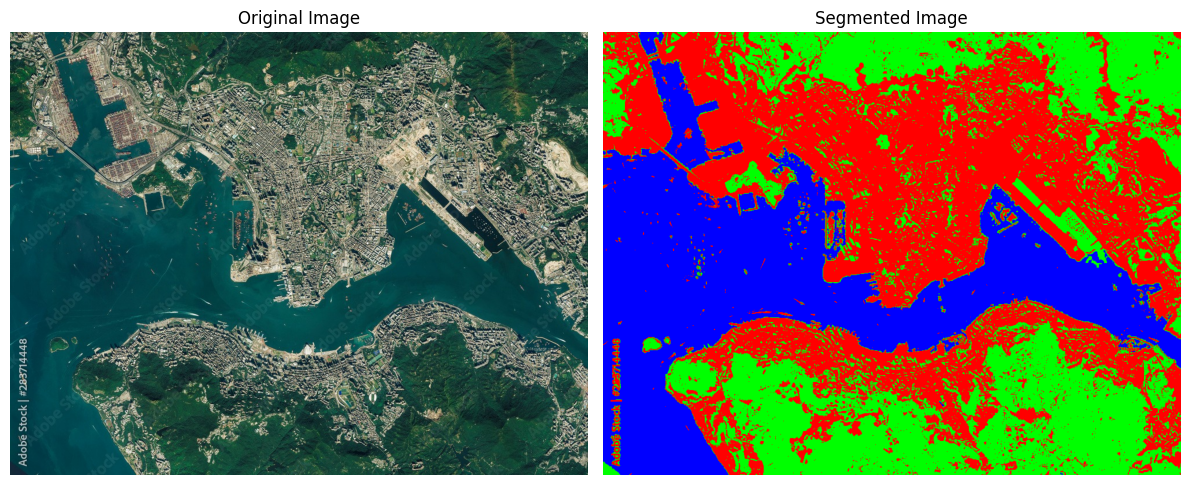

In [159]:
labels = gmm.predict(df1)  # your GMM cluster assignments (0, 1, 2)
segmented_img1 = create_segmented_image(labels, img1.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Segmented image
axes[1].imshow(cv2.cvtColor(segmented_img1, cv2.COLOR_BGR2RGB))
axes[1].set_title("Segmented Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [160]:
img2 = cv2.imread("../assets/data/satellite_2.png")
print(img2.shape)

# Creating a pd dataframe from image
df2 = pd.DataFrame(columns=["B", "G", "R"])

pixels = img2.reshape(-1, 3).astype("int32")
df2 = pd.DataFrame(pixels, columns=["B", "G", "R"])

# Scaling the values to be between 0 and 1
df2 = pd.DataFrame(pixels / 255.0, columns=["B", "G", "R"])

# Display info
print(len(df2))
print(df2.info())
print(df2.head())

(1600, 755, 3)
1208000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208000 entries, 0 to 1207999
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   B       1208000 non-null  float64
 1   G       1208000 non-null  float64
 2   R       1208000 non-null  float64
dtypes: float64(3)
memory usage: 27.6 MB
None
          B         G         R
0  0.278431  0.164706  0.105882
1  0.227451  0.113725  0.054902
2  0.211765  0.105882  0.050980
3  0.298039  0.196078  0.141176
4  0.282353  0.180392  0.125490


In [161]:
# Initializing K Means Clustering Class
K = 3    # Land, water and vegetation

gmm = GMM(K, seed)
gmm.fit(df2, 100)

Completed iteration 0 with likelihood: 3474101.5850419244
Completed iteration 5 with likelihood: 3677115.04508671
Completed iteration 10 with likelihood: 3803125.9929851107
Completed iteration 15 with likelihood: 3815197.4890427063
Completed iteration 20 with likelihood: 3816863.071407839
Completed iteration 25 with likelihood: 3817236.6990479254
Completed iteration 30 with likelihood: 3817356.55429956
Completed iteration 35 with likelihood: 3817404.1410078737
Completed iteration 40 with likelihood: 3817425.387330234
Completed iteration 45 with likelihood: 3817435.5119774374
Completed iteration 50 with likelihood: 3817440.5011908123
Completed iteration 55 with likelihood: 3817442.9861844196
Completed iteration 60 with likelihood: 3817444.212546478
Completed iteration 65 with likelihood: 3817444.7987488904
Completed iteration 70 with likelihood: 3817445.060461652
Completed iteration 75 with likelihood: 3817445.16078156


In [162]:
print(gmm.means)

          B         G         R
0  0.238178  0.156386  0.145098
1  0.437645  0.414981  0.449965
2  0.177197  0.281991  0.235833


In [163]:
print(gmm.pi)

[0.27892312 0.44866072 0.27241615]


In [164]:
for entry in gmm.cov:
    print(entry)

[[0.00518071 0.00398606 0.00288533]
 [0.00398606 0.00438621 0.00492803]
 [0.00288533 0.00492803 0.00978291]]
[[0.02725079 0.02774396 0.02721384]
 [0.02774396 0.03135386 0.03212068]
 [0.02721384 0.03212068 0.03503762]]
[[0.01040396 0.0082507  0.00982023]
 [0.0082507  0.01672875 0.01559863]
 [0.00982023 0.01559863 0.01717084]]


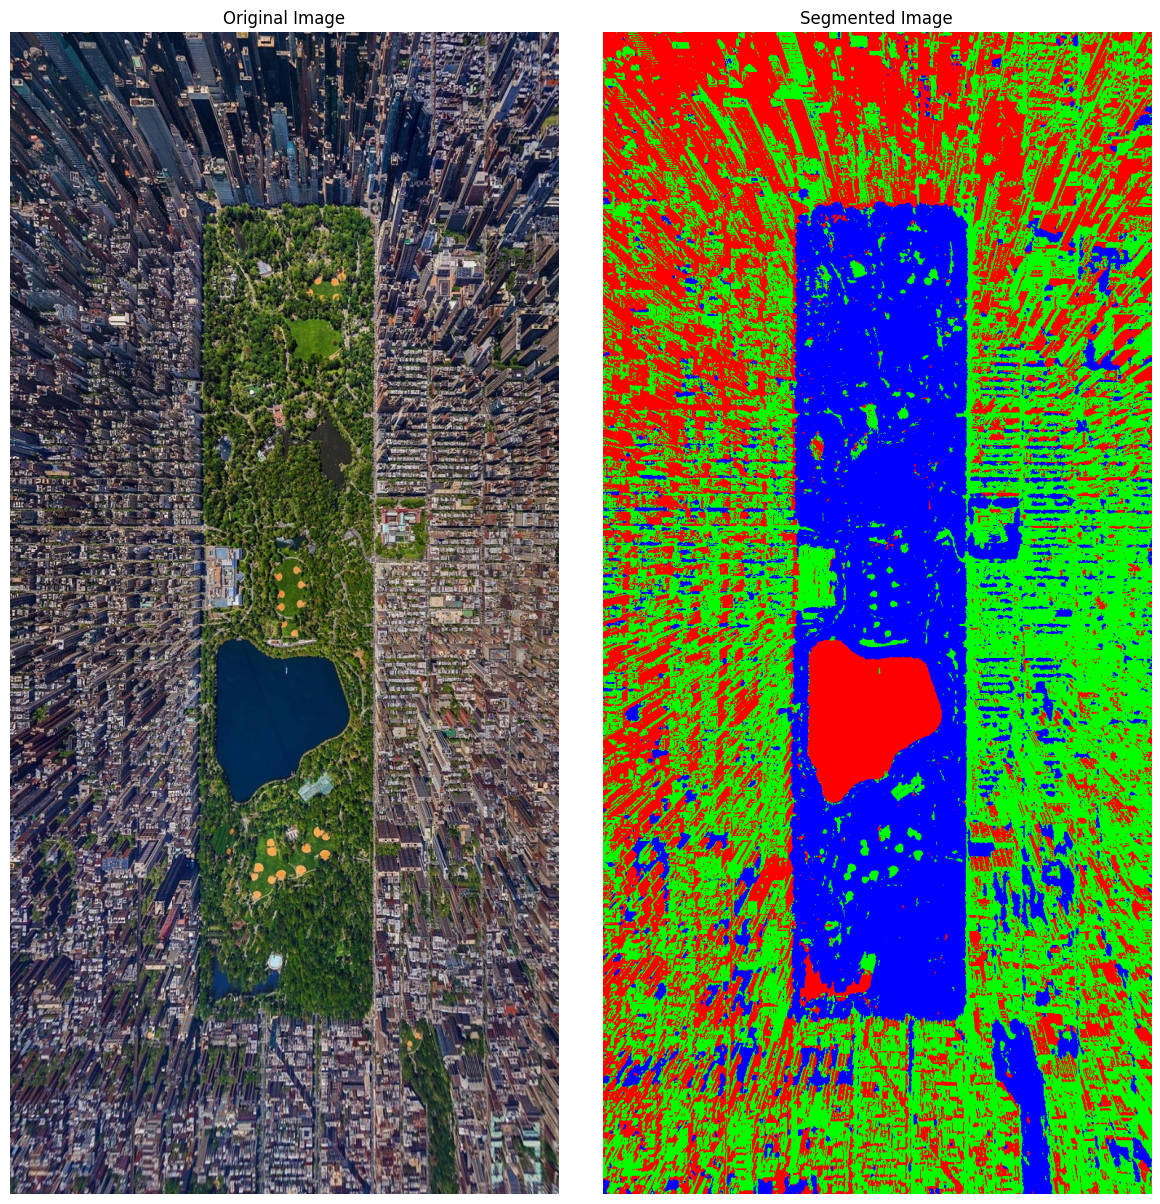

In [165]:
labels = gmm.predict(df2)
segmented_img2 = create_segmented_image(labels, img2.shape)

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 12))

# Original image
axes[0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Segmented image
axes[1].imshow(cv2.cvtColor(segmented_img2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Segmented Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()